# PREDICCIÓN DE EMOJI

## 1. Librerías a usar

In [3]:
import pandas as pd
import numpy as np
import emoji
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from tabulate import tabulate
import matplotlib.pyplot as plt

## 2. Carga y lectura de datos

In [4]:
# Cargar los datos de entrenamiento y de datos de los archivos csv
names_cols_train = ["Text", "Label", "C3", "C4"]
names_cols_test = ["Text", "Label"]
# Leer los datos de entrenamiento 
train = pd.read_csv("DATOS_PROYECTO_4/train_emoji.csv", header=None, names = names_cols_train)
test = pd.read_csv("DATOS_PROYECTO_4/test_emoji.csv", header=None, names = names_cols_test)

In [5]:
# Mostrar los 5 primeros datos de entrenamiento
train.head()

,Text,Label,C3,C4
0,never talk to me again,3,NaN,NaN
1,I am proud of your achievements,2,NaN,NaN
2,It is the worst day in my life,3,NaN,NaN
3,Miss you so much,0,NaN,[0]
4,food is life,4,NaN,NaN


In [6]:
# Mostrar los 5 primeros datos de entrenamiento
test.head()

,Text,Label
0,I want to eat\t,4
1,he did not answer\t,3
2,he got a raise\t,2
3,she got me a present\t,0
4,ha ha ha it was so funny\t,2


## 3. De etiquetas a Emojis
<p>El texto está etiquetado con números enteros que van del 0 al 4. Cada número entero corresponde a un emoji específico.</p>

In [7]:
# Creamos el diccionario para los emojis
diccionnario_emoji = {"0": ":heart:",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

# Función para convertir un números entero en emoji imprimible
def label_a_emoji(label):
    return emoji.emojize(diccionnario_emoji[str(label)], use_aliases=True)

# Mostrar las etiquetas y sus respectivos emojis
for i in range(5):
    print("Label", i, " :", label_a_emoji(i))

Label 0  : ❤️
Label 1  : ⚾
Label 2  : 😄
Label 3  : 😞
Label 4  : 🍴


In [8]:
# Mostrar los 5 primeros textos y sus respectivos emojis
data = train.values
for i in range(5):
    print(data[i][0], " :", label_a_emoji(data[i][1]))

never talk to me again  : 😞
I am proud of your achievements  : 😄
It is the worst day in my life  : 😞
Miss you so much  : ❤️
food is life  : 🍴


## 4. Obtenemos los datos de entrenamiento y de test

In [9]:
# Datos de entrenamiento
X_train = train["Text"]

# Datos de prueba
X_test = test["Text"]

In [10]:
# Muestra la máxima cantidad de palabras de un texto del dataset
maxLen = len(max(X_train, key=len).split())
print('La máxima cantidad de palabras de un texto del dataset es:',maxLen)

La máxima cantidad de palabras de un texto del dataset es: 10


Convertir los labels vectores one-hot

In [11]:
# Se realiza la conversión  de los labels o etiquetas de los datos de entrenamiento y de prueba a vectores One hot
Y_train = pd.get_dummies(train["Label"])
Y_test = pd.get_dummies(test["Label"])

In [12]:
# Muestra el tamaño del dataset procesado
print("Tamaño de los datos de entrenamiento:", X_train.shape, Y_train.shape)
print ("Tamaño de los datos de test:", X_test.shape, Y_test.shape)

Tamaño de los datos de entrenamiento: (132,) (132, 5)
Tamaño de los datos de test: (56,) (56, 5)


## 5. Cargar los vectores Glove 

Usaremos representaciones de vectores de palabras en las palabras en la oración, y usaremos los vectores Glove para esta representación. Basado en algunas iteraciones, los vectores 50d parecen funcionar mejor para este caso.


In [14]:
# FUNCIÓN: read_glove_vecs
def read_glove_vecs(glove_file):
    with open(glove_file,encoding='utf-8') as f:
        words = set()         # asegura valores únicos
        word_to_vec_map = {}  # creamos un diccionario para mapear las palabras
        for line in f:          
            # Elimina el primer y último espacio, y cada línea se divide por 
            # espacios. Devuelve una lista. El primer elemento es una palabra 
            # y el resto son representaciones de palabras incrustadas
            line = line.strip().split()  
            curr_word = line[0]        #  saca la palabra
            words.add(curr_word)       # add a la colección / diccionario
            word_to_vec_map[curr_word] = np.array(line[1:], dtype='float32')
        
        i = 1
        words_to_index = {}   # diccionario donde  mapeamos las palabras con el indice
        index_to_words = {}   # diccionario donde mapeamos el indice con la palabra
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('Glove_Embeddings/glove.6B.50d.txt')

Usaremos Keras para la implementación del LSTM. Por lo tanto, necesitamos crear una 'capa embedding'.

In [15]:
# FUNCIÓN: capa_embedding_preentrenada
def capa_embedding_preentrenada(word_to_vec_map, word_to_index):
    """
    Crea una capa Keras Embedding() y la carga en vectores GloVe de 50 dimensiones previamente entrenados.
     Argumentos:
     word_to_vec_map -- mapeo de diccionario de palabras a su representación vectorial GloVe.
     word_to_index -- mapeo de diccionario de palabras a sus índices en el vocabulario

     Devoluciones:
     embedding_layer -- capa pre-entrenada Keras
    """
    vocab_len = len(word_to_index) + 1 # agrega 1 para encajar en la incrustación (embedding) de Keras       
    emb_dim = word_to_vec_map["cucumber"].shape[0] # # define la dimensionalidad de los vectores de palabras GloVe (= 50)
    
    # Inicializa la matriz embedding como una matriz numpy de ceros de forma 
    # (vocab_len, dimensiones de los vectores de palabras = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Establece cada fila "índice" de la matriz embedding para que 
    # sea la representación vectorial de palabras de la palabra "índice" del vocabulario
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define la capa de incrustación de Keras con los tamaños correctos de salida/entrada, trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    
    # Construye la capa de incrustación, se requiere antes de configurar los pesos de la capa de incrustación.
    embedding_layer.build((None,))

    # Establezca los pesos de la capa embedding en la matriz embedding. La capa ahora está preentrenada.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

Cambiamos las sentencias a índices

In [16]:
# FUNCIÓN: sentencias_a_indices
def sentencias_a_indices(X, word_to_index, max_len):
    """
     Convierte una matriz de oraciones (cadenas) en una matriz de índices correspondientes a las palabras de las oraciones.
     La forma de salida debe ser tal que se pueda asignar a `Embedding()`.
     Argumentos:
     X -- conjunto de oraciones (cadenas), de forma (m, 1)
     word_to_index: un diccionario que contiene cada palabra asignada a su índice
     max_len -- número máximo de palabras en una oración. Puede asumir que cada oración en X no es más larga que esto.

     Devoluciones:
     X_indices: conjunto de índices correspondientes a las palabras en las oraciones de X, de forma (m, max_len)
     """
    m = X.shape[0] # cantidad de ejemplos de entrenamiento                               
    X_indices = np.zeros((m, max_len)) # Inicializa la matriz con ceros
    for i in range(m): # bucle de ejemplos de entrenamiento
        # Convierta la i-ésima oración de entrenamiento en minúsculas y divídala en palabras.
        sentence_words = (X[i].lower()).split()
        # Inicializa j a 0
        j = 0
        # Bucle de las palabras de sentencia_words
        for w in sentence_words:
            # Establecer la (i, j) ésima entrada de X_indices en el índice de la palabra correcta.
            X_indices[i, j] = word_to_index[w]
            j = j + 1
            
    return X_indices

X_train_indices = sentencias_a_indices(X_train, word_to_index, maxLen)
X_test_indices = sentencias_a_indices(X_test, word_to_index, maxLen)

## 6. Creamos el modelo de red neuronal

In [17]:
# Defina sentence_indices como la entrada del gráfico, debe tener la forma input_shape y el tipo 'int32' (ya que contiene índices).
sentence_indices = Input((maxLen,), dtype = 'int32')
# Cree la capa embedding preentrenada con GloVe Vectors
embedding_layer = capa_embedding_preentrenada(word_to_vec_map, word_to_index)
# Propagar sentence_indices a través de la capa embedding
embeddings = embedding_layer(sentence_indices)  
# Propagar los embeddings a través de una capa LSTM con un estado oculto de 128 dimensiones
X = LSTM(128, return_sequences=True)(embeddings)
# Agregar una capa dropout con una probabilidad de 0.5
X = Dropout(0.5)(X)
# Propagar X a través de otra capa LSTM con estado oculto de 128 dimensiones
X = LSTM(128, return_sequences=False)(X)
# Agregar una capa dropout con una probabilidad de 0.5
X = Dropout(0.5)(X)
# Propagar X a través de una capa densa para recuperar un lote de vectores de 5 dimensiones.
X = Dense(5)(X)
# Agregar una capa de activación de softmax
X = Activation('softmax')(X)
# Crear una instancia de Modelo que convierte los entence_indices en X.
model = Model(sentence_indices, X)


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

## 7. Compilación y entrenamiento del modelo

In [19]:
import tensorflow as tf
optimizador = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train_indices, Y_train, epochs = 40, batch_size = 16, shuffle=True, validation_data=(X_test_indices, Y_test))

Epoch 1/40
9/9 [==============================] - 5s 25ms/step - loss: 1.5912 - accuracy: 0.2197 - val_loss: 1.5087 - val_accuracy: 0.2857
Epoch 2/40
9/9 [==============================] - 0s 26ms/step - loss: 1.4781 - accuracy: 0.3485 - val_loss: 1.4646 - val_accuracy: 0.2857
Epoch 3/40
9/9 [==============================] - 0s 19ms/step - loss: 1.3836 - accuracy: 0.3712 - val_loss: 1.3663 - val_accuracy: 0.4464
Epoch 4/40
9/9 [==============================] - 0s 23ms/step - loss: 1.2251 - accuracy: 0.4924 - val_loss: 1.1874 - val_accuracy: 0.5000
Epoch 5/40
9/9 [==============================] - 0s 23ms/step - loss: 1.0441 - accuracy: 0.6061 - val_loss: 1.1769 - val_accuracy: 0.3929
Epoch 6/40
9/9 [==============================] - 0s 21ms/step - loss: 0.8232 - accuracy: 0.7197 - val_loss: 1.0413 - val_accuracy: 0.5000
Epoch 7/40
9/9 [==============================] - 0s 22ms/step - loss: 0.6923 - accuracy: 0.7273 - val_loss: 1.1809 - val_accuracy: 0.4643
Epoch 8/40
9/9 [===========

## 8. Prueba y validación

In [23]:
loss, acc = model.evaluate(X_test_indices, Y_test)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 5ms/step - loss: 1.5971 - accuracy: 0.6250

Test accuracy =  0.625


### Ploteo

Text(0, 0.5, 'Accuracy')

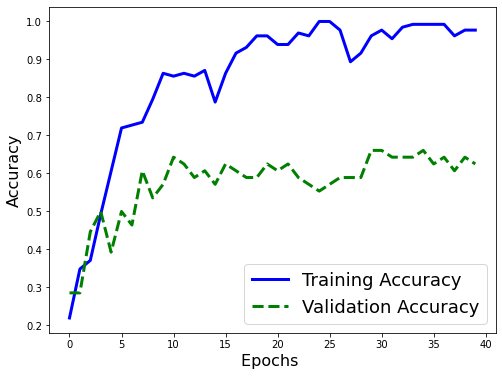

In [24]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'blue',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'green',ls = '--',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18, 
           loc = 'lower right')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

### Predicción con los datos de prueba

In [63]:
Y_test_lbl = test["Label"]
Y_test_oh = pd.get_dummies(Y_test_lbl)
X_test_indices = sentencias_a_indices(test["Text"], word_to_index, maxLen)
pred = model.predict(X_test_indices)
y_pred =[]
tabla_predict = []
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    y_pred.append(np.argmax(pred[i]))
    tabla_predict.append([X_test[i],label_a_emoji(Y_test_lbl[i]),label_a_emoji(num).strip()])

### Matriz de Confusión

In [92]:
def matriz_confusion(y_actu, y_pred, title='Matriz de Confusión', cmap=plt.cm.Blues):
    
    df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'])
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap)  
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    

In [93]:
# Transformamos los datos de la predicion y de test en arrays
y_pred = np.array(y_pred)
y_actu = np.array(Y_test_lbl)

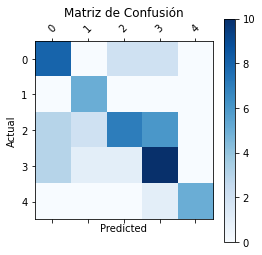

In [94]:
# Mostramos la matriz de confusión Multiclases
matriz_confusion(y_actu,y_pred)

In [26]:
print(tabulate(tabla_predict, headers=["Texto", "Label", "Predicción"]))

Texto                                  Label    Predicción
-------------------------------------  -------  ------------
I want to eat                          🍴       🍴
he did not answer                      😞       😞
he got a raise                         😄       😞
she got me a present                   ❤️        😞
ha ha ha it was so funny               😄       😄
he is a good friend                    ❤️        ❤️
I am upset                             ❤️        😞
We had such a lovely dinner tonight    ❤️        😄
where is the food                      🍴       🍴
Stop making this joke ha ha ha         😄       😄
where is the ball                      ⚾       ⚾
work is hard                           😞       😞
This girl is messing with me           😞       ❤️
are you serious ha ha                  😄       😞
Let us go play baseball                ⚾       ⚾
This stupid grader is not working      😞       😞
work is horrible                       😞       😞
Congratulation for having a baby     